In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

import os
import pandas as pd
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, \
MaxPooling2D, Conv2D, Lambda, Cropping2D, Convolution2D,\
AveragePooling2D
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.cross_validation import train_test_split

from copy import deepcopy
from sklearn.utils import shuffle


from generator import generator
from get_images import get_images

from keras.optimizers import Adam


Using TensorFlow backend.
/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
datadirs=['/notebooks/udacity/new_training/map1_backward/',
                 '/notebooks/udacity/new_training/map1_forward/',
                 '/notebooks/udacity/new_training/map1_recovery_backward/',
                 '/notebooks/udacity/new_training/map1_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_forward/',
                 '/notebooks/udacity/new_training/map2_backward/',
                 '/notebooks/udacity/new_training/map2_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_recovery_backward/',
                   '/notebooks/udacity/new_training/map1_error_correction/',
                   '/notebooks/udacity/new_training/map2_error_correction/'
         ]

#datadirs=['/notebooks/udacity/car_data/data/']

images=get_images(datadirs,0.1)

In [4]:
size=(40,80)

def preprocessing_resize(im):
    return cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2YUV),(size[1],size[0]))

def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)



In [5]:
from car_models import *

In [6]:
grid=[{'get_model':modified_lenet, 'correction':0.09, \
       'preprocessing':preprocessing_resize,'optimizer':Adam(lr=0.01),'gpu':'0','name':'lenet_02_adam'},\
     {'get_model':nvidia_net, 'correction':0.09, \
       'preprocessing':preprocessing_yuv,'optimizer':Adam(lr=0.01),'gpu':'0','name':'nvidia_net_02_adam'},
      {'get_model':inception, 'correction':0.09, \
       'preprocessing':lambda x:x,'optimizer':Adam(lr=0.01),'gpu':'0','name':'inception_02_adam'},
     {'get_model':vgg16, 'correction':0.09, \
       'preprocessing':lambda x:x,'optimizer':Adam(lr=0.01),'gpu':'0','name':'vgg16_02_adam'},
      ]

In [ ]:
import os
import pickle

def train_model(get_model, correction, preprocessing, name, optimizer, gpu,leftright_weight=1):
    import os

    os.environ['CUDA_VISIBLE_DEVICES']=str(gpu)
    
    model=get_model()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
    
    if not os.path.exists('results/logs_%s'%name):
        os.mkdir('results/logs_%s'%name)
    
    
    checkpoint = ModelCheckpoint("results/model_%s.h5" % name, monitor='val_mean_squared_error', verbose=1,
                              save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                               min_delta=0.001, patience=3,
                                verbose=1, mode='min')

    history = History()

    tb=TensorBoard(log_dir='results/logs_%s'%name, histogram_freq=0, write_graph=True, write_images=False)

    train_generator = generator(deepcopy(images), dataset=0, batch_size=32, preprocessing=preprocessing,\
                               leftright_weight=leftright_weight)
    validation_generator = generator(deepcopy(images), dataset=1, batch_size=32, preprocessing=preprocessing,\
                                    leftright_weight=leftright_weight)
    test_generator = generator(deepcopy(images), dataset=2, batch_size=32, preprocessing=preprocessing,\
                              leftright_weight=leftright_weight)

    ##todo - nb_epoch=100
    q=model.fit_generator(train_generator, \
                    samples_per_epoch=len(images[images.dataset==0]),\
                    nb_epoch=100,\
                    verbose=1,\
                    validation_data=validation_generator, \
                    nb_val_samples=len(images[images.dataset==1]),\
                    callbacks=[checkpoint, early_stop,history,tb]\
                   )
    
    f=open('results/history_%s.pk1' % name,'wb')
    pickle.dump(history.history,f,-1)
    f.close()
    
    #realy it's from last iteration - better to load best model here
    res=model.evaluate_generator(test_generator,val_samples=len(images[images.dataset==1]))[0]
    return q,res

In [ ]:
res=[]
errs=[]
for a in grid:
    print (a)
    try:
        tmp=train_model(**a)
    except:
        errs.append(a)
        tmp=-1
    res.append(tmp)

{'correction': 0.09, 'get_model': <function modified_lenet at 0x7f2e037f5f28>, 'name': 'lenet_02_adam', 'optimizer': <keras.optimizers.Adam object at 0x7f2e032ed438>, 'preprocessing': <function preprocessing_resize at 0x7f2e035d4510>, 'gpu': '0'}
Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
 72576/220488 [========>.....................] - ETA: 149s - loss: 0.0957 - mean_squared_error: 0.0957 

In [1]:
%%sh

rm -r results/*

In [ ]:
res3=[train_model(**a) for a in grid]

In [7]:
%%sh

rm -r results/*

In [14]:
res[1][0].history

{'loss': [0.3437612208133512,
  0.16276085782613806,
  0.1627599917505477,
  0.16278721181594219,
  0.16278557966733498],
 'mean_squared_error': [0.3437612208133512,
  0.16276085782613806,
  0.1627599917505477,
  0.16278721181594219,
  0.16278557966733498],
 'val_loss': [0.16519475767737357,
  0.16481634419605498,
  0.16559190217672073,
  0.16507394580480547,
  0.16506405453250503],
 'val_mean_squared_error': [0.16519475767737357,
  0.16481634419605498,
  0.16559190217672073,
  0.16507394580480547,
  0.16506405453250503]}

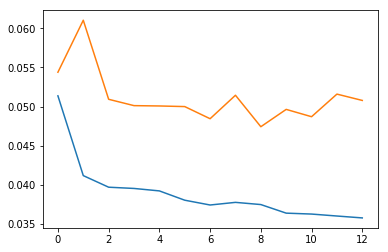

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(res[1][0].history['loss'])
plt.plot(res[1][0].history['val_loss'])



In [7]:
def nvidia_net_mod():
    """
    neural network from Nvidia paper
    """
    model=Sequential()

    model.add(Cropping2D(cropping=((50,20), (0,0)), \
                         input_shape=(160,320,3)))

    model.add(Lambda(lambda x: (x / 255.0) - 0.5))

    model.add(Convolution2D(24, 5, 5,  border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.5))

    model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))

    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Flatten())


    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    return model

In [7]:
def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)



params={'get_model':nvidia_net, 'correction':0.08, \
       'preprocessing':preprocessing_yuv,'optimizer':Adam(lr=0.01),\
        'gpu':'0','name':'nvidia_net_mod_02_adam_smalldata'}

In [ ]:
q=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
220488/220488 [==============================] - 378s - loss: 0.0667 - mean_squared_error: 0.0667 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 2/100
  9824/220488 [>.............................] - ETA: 334s - loss: 0.0603 - mean_squared_error: 0.0603

In [12]:
params={'get_model':modified_lenet, 'correction':0.2, \
       'preprocessing':preprocessing_resize,'optimizer':'adam','gpu':'0','name':'lenet_smalldata'}

In [13]:
q2=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
38568/38568 [==============================] - 43s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 2/100
38568/38568 [==============================] - 42s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0538 - val_mean_squared_error: 0.0538
Epoch 3/100
38568/38568 [==============================] - 42s - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0471 - val_mean_squared_error: 0.0471
Epoch 4/100
38568/38568 [==============================] - 42s - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 5/100
38568/38568 [==============================] - 42s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0419 - val_mean_squared_error: 0.0419
Epoch 6/100
38568/38568 [==============================] - 42s - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0446 - val_mean_sq

KeyboardInterrupt: 

In [15]:
images=images[images.inverse==False]

In [9]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ConvLSTM2D, Dense, MaxPooling2D, Dropout, Flatten, Reshape, merge, Input



def proc_img(img): # input is 160x320x3
    img = img[59:138:2, 0:-1:2, :] # select vertical region and take each second pixel to reduce image dimensions
    img = (img / 127.5) - 1.0 # normalize colors from 0-255 to -1.0 to 1.0
    return img # return 40x160x3 image



    # ----------------------
# Model - ideas from VG type network
inp = Input(shape=(40,160,3))
# First convolution is for model to determine the 'best' colorspace weights
x = Conv2D(3, 1, 1, border_mode='same', activation='relu')(inp)
# Reduce dimensions
x = MaxPooling2D((2,2))(x) #20x80

# First convolution layer
x1 = Conv2D(32, 3, 3, border_mode='same', activation='relu')(x)
x1 = Conv2D(32, 3, 3, border_mode='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2))(x1) #10x40
x1 = Dropout(0.5)(x1)
flat1 = Flatten()(x1) # Used for the merge before first fully connected layer

# Second convolution layer
x2 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x1)
x2 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x2)
x2 = MaxPooling2D((2,2))(x2) #5x20
x2 = Dropout(0.5)(x2)
flat2 = Flatten()(x2) # Used for the merge before first fully connected layer

# Second convolution layer
x3 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x2)
x3 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x3)
x3 = MaxPooling2D((2,2))(x3) #2x10
x3 = Dropout(0.5)(x3)
flat3 = Flatten()(x3) # Used for the merge before first fully connected layer

# Merge the flattened ouputs after each convolution layer
x4 = merge([flat1, flat2, flat3], mode='concat')
# Fully connected layers
x5 = Dense(512, activation='relu')(x4)
x6 = Dense(128, activation='relu')(x5)
x7 = Dense(16, activation='relu')(x6)
out = Dense(1, activation='linear')(x7)

model = Model(input=inp, output=out)
    #model.summary()
    #return model



In [ ]:
def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)

params={'get_model':qqq, 'correction':0.09, \
       'preprocessing':proc_img,'optimizer':Adam(lr=0.0001),'gpu':'0','name':'fuck'}

q=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
220488/220488 [==============================] - 250s - loss: 0.0650 - mean_squared_error: 0.0650 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 2/100
 97120/220488 [============>.................] - ETA: 127s - loss: 0.0548 - mean_squared_error: 0.0548

In [19]:
q[0].history['val_loss']

[0.058320034539132141,
 0.052179218986858358,
 0.048684213434278041,
 0.045051105501555409,
 0.043774581044650686,
 0.04172890246273419,
 0.041287207144807617,
 0.040170257946765833,
 0.040156293845558577,
 0.040138430012239462,
 0.039448622248698141,
 0.039587236452156289]

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.show()

In [18]:
images[images.steering!=0].groupby('side').size()

side
-1    7350
 0    7350
 1    7350
dtype: int64

In [21]:
images[images.img.apply(lambda x:'left_2016_12_01_13_32_48_402.jpg' in x)].steering.values[0]+0.08

0.02024281

In [22]:
len(images)

24108

In [23]:
%%sh

cat /notebooks/udacity/car_data/data/driving_log.csv | wc -l

8037


In [29]:
images=images[images.side!=0]

In [44]:
images.to_pickle('images.pk1')

In [4]:

def generate_image_batch(names, y_data, batch_size = 32):
    total_items = len(names)
    curr_item = 0
    while (True):
        image_data = np.zeros((batch_size,40, 160, 3),dtype=float)
        steering_data = np.zeros((batch_size),dtype=float)
        for j in range(batch_size):
            image_name = names[curr_item]
            image = cv2.imread(image_name)
            image_data[j] = proc_img(image)
            steering_data[j] = y_data[curr_item]
            curr_item = (curr_item+1)%total_items
        yield image_data, steering_data


In [14]:
import random
random.randint(0,1)

1

In [21]:
import random



def generate_image_batch(names, y_data, batch_size = 32):
    names, y_data=shuffle(names, y_data)
    total_items = len(names)
    curr_item = 0
    while (True):
        image_data = np.zeros((batch_size,40, 160, 3),dtype=float)
        steering_data = np.zeros((batch_size),dtype=float)
        for j in range(batch_size):
            image_name = names[curr_item]
            image = cv2.imread(image_name)
            image_data[j] = proc_img(image)
            steering_data[j] = y_data[curr_item]
            curr_item = curr_item+1
            if random.randint(0,1)==1:
                steering_data[j]*=-1
                image_data[j]=np.fliplr(image_data[j])
            if curr_item>=total_items:
                curr_item=0
                names, y_data = shuffle(names, y_data)
        
        yield image_data, steering_data



In [54]:
images['real']=images.steering+images.side*0.08

In [5]:
images1=images[(images.inverse==1)]

In [6]:
names=images1.img.values
y=images1.real.values

In [7]:
from sklearn.utils import shuffle
names,y=shuffle(names,y)

In [ ]:
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("model_test.h5" , monitor='val_mean_squared_error', verbose=1,
                          save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                           min_delta=0.001, patience=3,
                            verbose=1, mode='min')

# Compile, train and save
#model.compile(optimizer=Adam(lr=FLAGS.learn_rate), loss='mse')


model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mean_squared_error'])


print ('Split data')
X_tr_names, X_val_names, y_tr, y_val = train_test_split(names,y,test_size=0.1)#newRandomTestValidationSplit(image_names_full, y_data_full)

print ('Start training')
# Training and validation inputs are fed from generators
# Number of samples based on data_set size and adjusted to fit batch size
history = model.fit_generator(generate_image_batch(X_tr_names, y_tr, 128),samples_per_epoch=len(y_tr),
                              nb_epoch=100,
                              validation_data=generate_image_batch(X_val_names, y_val, 32),\
                             nb_val_samples=len(y_val),callbacks=[checkpoint, early_stop])


Split data
Start training
Epoch 1/100
123904/124027 [============================>.] - ETA: 0s - loss: 0.0459 - mean_squared_error: 0.0459  

/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_mean_squared_error improved from inf to 0.04250, saving model to model_test.h5
124032/124027 [==============================] - 114s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 2/100
124032/124027 [==============================] - 112s - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 3/100
124032/124027 [==============================] - 113s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 4/100
124032/124027 [==============================] - 112s - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0399 - val_mean_squared_error: 0.0399
Epoch 5/100
124032/124027 [==============================] - 112s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 6/100
124032/124027 [==============================] - 112s - loss: 0.0348 - mean_squared_error: 0.0

In [17]:
q=generate_image_batch(X_val_names, y_val, 32)

In [20]:
next(q)

(array([[[[-0.94509804, -0.83529412, -0.86666667],
          [-0.94509804, -0.83529412, -0.86666667],
          [-0.95294118, -0.84313725, -0.8745098 ],
          ..., 
          [-0.67058824, -0.49803922, -0.5372549 ],
          [-0.7254902 , -0.52156863, -0.56862745],
          [-0.67843137, -0.43529412, -0.49019608]],
 
         [[-0.94509804, -0.83529412, -0.86666667],
          [-0.95294118, -0.84313725, -0.8745098 ],
          [-0.96078431, -0.85098039, -0.88235294],
          ..., 
          [-0.61568627, -0.45882353, -0.49803922],
          [-0.61568627, -0.41176471, -0.45882353],
          [-0.58431373, -0.36470588, -0.41176471]],
 
         [[-0.94509804, -0.83529412, -0.86666667],
          [-0.95294118, -0.84313725, -0.8745098 ],
          [-0.96862745, -0.85882353, -0.89019608],
          ..., 
          [-0.43529412, -0.27843137, -0.31764706],
          [-0.67058824, -0.49019608, -0.52941176],
          [-0.55294118, -0.33333333, -0.38039216]],
 
         ..., 
         [